In [16]:
import os
import tensorflow as tf
import numpy as np

# import helper
from glob import glob
import pickle as pkl
import scipy.misc

import math
import os
import hashlib
from urllib.request import urlretrieve
import shutil

import numpy as np
from PIL import Image

import time

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

do_preprocess = True
from_checkpoint = False

In [17]:
data_dir = '/home/mele/datasets/plant_deases/color/Potato___healthy/' # Data
data_resized_dir = "img_resized"# Resized data

if do_preprocess == True:
    if (not os.path.exists):
        os.mkdir(data_resized_dir)

    for each in os.listdir(data_dir):
        image = cv2.imread(os.path.join(data_dir, each))
        image = cv2.resize(image, (64, 64))
        cv2.imwrite(os.path.join(data_resized_dir, each), image)


In [18]:
# Helper functions

def get_image(image_path, width, height, mode):
    """
    Read image from image_path
    :param image_path: Path of image
    :param width: Width of image
    :param height: Height of image
    :param mode: Mode of image
    :return: Image data
    """
    image = Image.open(image_path)


    return np.array(image.convert(mode))


def get_batch(image_files, width, height, mode):
    data_batch = np.array(
        [get_image(sample_file, width, height, mode) for sample_file in image_files]).astype(np.float32)

    # Make sure the images are in 4 dimensions
    if len(data_batch.shape) < 4:
        data_batch = data_batch.reshape(data_batch.shape + (1,))

    return data_batch

def images_square_grid(images, mode):
    """
    Save images as a square grid
    :param images: Images to be used for the grid
    :param mode: The mode to use for images
    :return: Image of images in a square grid
    """
    # Get maximum size for square grid of images
    import math
    save_size = math.floor(np.sqrt(images.shape[0]))

    # Scale to 0-255
    images = (((images - images.min()) * 255) / (images.max() - images.min())).astype(np.uint8)

    # Put images in a square arrangement
    images_in_square = np.reshape(
            images[:save_size*save_size],
            (save_size, save_size, images.shape[1], images.shape[2], images.shape[3]))
    if mode == 'L':
        images_in_square = np.squeeze(images_in_square, 4)

    # Combine images to grid image
    new_im = Image.new(mode, (images.shape[1] * save_size, images.shape[2] * save_size))
    for col_i, col_images in enumerate(images_in_square):
        for image_i, image in enumerate(col_images):
            im = Image.fromarray(image, mode)
            new_im.paste(im, (col_i * images.shape[1], image_i * images.shape[2]))

    return new_im

class Dataset(object):
    """
    Dataset
    """
    def __init__(self, data_files):
        """
        Initalize the class
        :param dataset_name: Database name
        :param data_files: List of files in the database
        """
        IMAGE_WIDTH = 64
        IMAGE_HEIGHT = 64

        self.image_mode = 'RGB'
        image_channels = 3

        self.data_files = data_files
        self.shape = len(data_files), IMAGE_WIDTH, IMAGE_HEIGHT, image_channels

    def get_batches(self, batch_size):
        """
        Generate batches
        :param batch_size: Batch Size
        :return: Batches of data
        """
        IMAGE_MAX_VALUE = 255

        current_index = 0
        while current_index + batch_size <= self.shape[0]:
            data_batch = get_batch(
                self.data_files[current_index:current_index + batch_size],
                *self.shape[1:3],
                self.image_mode)
            
            current_index += batch_size

            yield data_batch / IMAGE_MAX_VALUE - 0.5

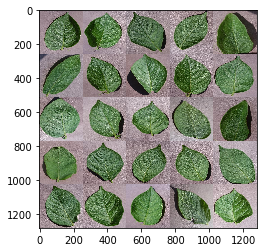

In [19]:
# Explore the data

show_n_images = 25
images = get_batch(glob(os.path.join(data_dir, '*.JPG'))[:show_n_images], 64, 64, 'RGB')
plt.imshow(images_square_grid(images, 'RGB'))

In [20]:
# Taken from Udacity face generator project
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.6.0


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:12: UserWarning: No GPU found. Please use a GPU to train your neural network.
  if sys.path[0] == '':


In [21]:
def model_inputs(real_dim, z_dim):
    """
    Create the model inputs
    :param real_dim: tuple containing width, height and channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate G, learning rate D)
    """
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name="input_z")
    learning_rate_G = tf.placeholder(tf.float32, name="learning_rate_G")
    learning_rate_D = tf.placeholder(tf.float32, name="learning_rate_D")
    
    return inputs_real, inputs_z, learning_rate_G, learning_rate_D

In [22]:
# Generator

def generator(z, output_channel_dim, is_train=True):
    ''' Build the generator network.
    
        Arguments
        ---------
        z : Input tensor for the generator
        output_channel_dim : Shape of the generator output
        n_units : Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out: 
    '''
    with tf.variable_scope("generator", reuse= not is_train):
        
        # First FC layer --> 8x8x1024
        fc1 = tf.layers.dense(z, 8*8*1024)
        
        # Reshape it
        fc1 = tf.reshape(fc1, (-1, 8, 8, 1024))
        
        # Leaky ReLU
        fc1 = tf.nn.leaky_relu(fc1, alpha=alpha)

        
        # Transposed conv 1 --> BatchNorm --> LeakyReLU
        # 8x8x1024 --> 16x16x512
        trans_conv1 = tf.layers.conv2d_transpose(inputs = fc1,
                                  filters = 512,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv1")
        
        batch_trans_conv1 = tf.layers.batch_normalization(inputs = trans_conv1, training=is_train, epsilon=1e-5, name="batch_trans_conv1")
       
        trans_conv1_out = tf.nn.leaky_relu(batch_trans_conv1, alpha=alpha, name="trans_conv1_out")
        
        
        # Transposed conv 2 --> BatchNorm --> LeakyReLU
        # 16x16x512 --> 32x32x256
        trans_conv2 = tf.layers.conv2d_transpose(inputs = trans_conv1_out,
                                  filters = 256,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv2")
        
        batch_trans_conv2 = tf.layers.batch_normalization(inputs = trans_conv2, training=is_train, epsilon=1e-5, name="batch_trans_conv2")
       
        trans_conv2_out = tf.nn.leaky_relu(batch_trans_conv2, alpha=alpha, name="trans_conv2_out")
        
        
        # Transposed conv 3 --> BatchNorm --> LeakyReLU
        # 32x32x256 --> 64x64x128
        trans_conv3 = tf.layers.conv2d_transpose(inputs = trans_conv2_out,
                                  filters = 128,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv3")
        
        batch_trans_conv3 = tf.layers.batch_normalization(inputs = trans_conv3, training=is_train, epsilon=1e-5, name="batch_trans_conv3")
       
        trans_conv3_out = tf.nn.leaky_relu(batch_trans_conv3, alpha=alpha, name="trans_conv3_out")

        
        # Transposed conv 4 --> BatchNorm --> LeakyReLU
        # 64x64x128 --> 128x128x64
        trans_conv4 = tf.layers.conv2d_transpose(inputs = trans_conv3_out,
                                  filters = 64,
                                  kernel_size = [5,5],
                                  strides = [2,2],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="trans_conv4")
        
        batch_trans_conv4 = tf.layers.batch_normalization(inputs = trans_conv4, training=is_train, epsilon=1e-5, name="batch_trans_conv4")
       
        trans_conv4_out = tf.nn.leaky_relu(batch_trans_conv4, alpha=alpha, name="trans_conv4_out")

        
        # Transposed conv 5 --> tanh
        # 128x128x64 --> 128x128x3
        logits = tf.layers.conv2d_transpose(inputs = trans_conv4_out,
                                  filters = 3,
                                  kernel_size = [5,5],
                                  strides = [1,1],
                                  padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name="logits")
         
        out = tf.tanh(logits, name="out")
        
        return out

In [23]:
# Discriminator

def discriminator(x, is_reuse=False, alpha = 0.2):
    ''' Build the discriminator network.
    
        Arguments
        ---------
        x : Input tensor for the discriminator
        n_units: Number of units in hidden layer
        reuse : Reuse the variables with tf.variable_scope
        alpha : leak parameter for leaky ReLU
        
        Returns
        -------
        out, logits: 
    '''
    with tf.variable_scope("discriminator", reuse = is_reuse): 
        
        # Input layer 128*128*3 --> 64x64x64
        # Conv --> BatchNorm --> LeakyReLU   
        conv1 = tf.layers.conv2d(inputs = x,
                                filters = 64,
                                kernel_size = [5,5],
                                strides = [2,2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv1')
        
        batch_norm1 = tf.layers.batch_normalization(conv1,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm1')

        conv1_out = tf.nn.leaky_relu(batch_norm1, alpha=alpha, name="conv1_out")
        
        
        # 64x64x64--> 32x32x128
        # Conv --> BatchNorm --> LeakyReLU   
        conv2 = tf.layers.conv2d(inputs = conv1_out,
                                filters = 128,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv2')
        
        batch_norm2 = tf.layers.batch_normalization(conv2,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                     name = 'batch_norm2')
        
        conv2_out = tf.nn.leaky_relu(batch_norm2, alpha=alpha, name="conv2_out")        
        
        # 32x32x128 --> 16x16x256
        # Conv --> BatchNorm --> LeakyReLU   
        conv3 = tf.layers.conv2d(inputs = conv2_out,
                                filters = 256,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv3')
        
        batch_norm3 = tf.layers.batch_normalization(conv3,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm3')
        
        conv3_out = tf.nn.leaky_relu(batch_norm3, alpha=alpha, name="conv3_out")

        # 16x16x256 --> 16x16x512
        # Conv --> BatchNorm --> LeakyReLU   
        conv4 = tf.layers.conv2d(inputs = conv3_out,
                                filters = 512,
                                kernel_size = [5, 5],
                                strides = [1, 1],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv4')
        
        batch_norm4 = tf.layers.batch_normalization(conv4,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm4')
        
        conv4_out = tf.nn.leaky_relu(batch_norm4, alpha=alpha, name="conv4_out")        
        
        # 16x16x512 --> 8x8x1024
        # Conv --> BatchNorm --> LeakyReLU   
        conv5 = tf.layers.conv2d(inputs = conv4_out,
                                filters = 1024,
                                kernel_size = [5, 5],
                                strides = [2, 2],
                                padding = "SAME",
                                kernel_initializer=tf.truncated_normal_initializer(stddev=0.02),
                                name='conv5')
        
        batch_norm5 = tf.layers.batch_normalization(conv5,
                                                   training = True,
                                                   epsilon = 1e-5,
                                                name = 'batch_norm5')
        
        conv5_out = tf.nn.leaky_relu(batch_norm5, alpha=alpha, name="conv5_out")

         
        # Flatten it
        flatten = tf.reshape(conv5_out, (-1, 8*8*1024))
        
        # Logits
        logits = tf.layers.dense(inputs = flatten,
                                units = 1,
                                activation = None)
        
        
        out = tf.sigmoid(logits)
        
        return out, logits

In [24]:
def model_loss(input_real, input_z, output_channel_dim, alpha):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # Generator network here
    g_model = generator(input_z, output_channel_dim)   
    # g_model is the generator output
    
    # Discriminator network here
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model,is_reuse=True, alpha=alpha)
    
    # Calculate losses
    d_loss_real = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                          labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
                  tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                          labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake

    g_loss = tf.reduce_mean(
             tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake,
                                                     labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss

In [25]:
def model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """    
    # Get the trainable_variables, split into G and D parts
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith("generator")]
    d_vars = [var for var in t_vars if var.name.startswith("discriminator")]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    # Generator update
    gen_updates = [op for op in update_ops if op.name.startswith('generator')]
    
    # Optimizers
    with tf.control_dependencies(gen_updates):
        d_train_opt = tf.train.AdamOptimizer(learning_rate=lr_D, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate=lr_G, beta1=beta1).minimize(g_loss, var_list=g_vars)
        
    return d_train_opt, g_train_opt

In [26]:
def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode, image_path, save, show):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    :param image_path: Path to save the image
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = images_square_grid(samples, image_mode)
    
    if save == True:
        # Save image
        images_grid.save(image_path, 'JPG')
    
    if show == True:
        plt.imshow(images_grid, cmap=cmap)
        plt.show()

In [27]:
from_checkpoint = False

def train(epoch_count, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, get_batches, data_shape, data_image_mode, alpha):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # Create our input placeholders
    input_images, input_z, lr_G, lr_D = model_inputs(data_shape[1:], z_dim)
        
    # Losses
    d_loss, g_loss = model_loss(input_images, input_z, data_shape[3], alpha)
    
    losses = [d_loss, g_loss]
    
    # Optimizers
    d_opt, g_opt = model_optimizers(d_loss, g_loss, lr_D, lr_G, beta1)
    
    i = 0
    
    version = "firstTrain"
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        # Saver
        saver = tf.train.Saver()
        
        num_epoch = 0
        
        if from_checkpoint == True:
            saver.restore(sess, "./models/model.ckpt")
            
            show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path, True, False)
            
        else:
            for epoch_i in range(epoch_count):        
                num_epoch += 1

                if num_epoch % 10 == 0:

                    # Save model every 5 epochs
                    #if not os.path.exists("models/" + version):
                    #    os.makedirs("models/" + version)
                    save_path = saver.save(sess, "./models/model.ckpt")
                    print("Model saved")

                for batch_images in get_batches(batch_size):
                    # Random noise
                    batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                    i += 1

                    # Run optimizers
                    _ = sess.run(d_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_D: learning_rate_D})
                    _ = sess.run(g_opt, feed_dict={input_images: batch_images, input_z: batch_z, lr_G: learning_rate_G})

                    if i % 10 == 0:
                        train_loss_d = d_loss.eval({input_z: batch_z, input_images: batch_images})
                        train_loss_g = g_loss.eval({input_z: batch_z})

                        # Save it
                        image_name = str(i) + ".JPG"
                        image_path = "generated_plant_leaf/" + image_name
                        show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path, True, False) 

                    # Print every 5 epochs (for stability overwize the jupyter notebook will bug)
                    if i % 50 == 0:

                        image_name = str(i) + ".JPG"
                        image_path = "generated_plant_leaf" + image_name
                        print("Epoch {}/{}...".format(epoch_i+1, epochs),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                        show_generator_output(sess, 4, input_z, data_shape[3], data_image_mode, image_path, False, True)    
                    
    return losses

In [28]:
# Size input image for discriminator
# real_size = (256,256,3)

# Size of latent vector to generator
z_dim = 50
learning_rate_D =  .00005 # Thanks to Alexia Jolicoeur Martineau https://ajolicoeur.wordpress.com/cats/
learning_rate_G = 2e-4 # Thanks to Alexia Jolicoeur Martineau https://ajolicoeur.wordpress.com/cats/
batch_size = 64
epochs = 51
alpha = 0.2
beta1 = 0.5

# Create the network
#model = DGAN(real_size, z_size, learning_rate, alpha, beta1)

In [15]:
# Load the data and train the network here
dataset = Dataset(glob(os.path.join('./img_resized/', '*.JPG')))

with tf.Graph().as_default():
    losses = train(epochs, batch_size, z_dim, learning_rate_D, learning_rate_G, beta1, dataset.get_batches,
          dataset.shape, dataset.image_mode, alpha)

152


In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()